## Final Project: Phase 3 - Avoiding False Discoveries
Spring 2024  
Group: Michael Massone and Joseph Nelson Farrell   
DS 5230 Unsupervised Machine Learning  
Professor Steven Morin, PhD  
Due: 04/17/2024  
___

### Import Libraries

In [1]:
# base
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# pathing
from pathlib import Path
import os
import sys

import umap

### Set Paths

In [2]:
# define path
HOME = Path(os.getcwd())
print(HOME)

HOME_PARENT_STR = str(HOME.parent)
print(HOME_PARENT_STR)

# path to figs folder
PATH_TO_FIGS_FOLDER = HOME_PARENT_STR + '/figs'

# path to data
PATH_TO_DATA_FOLDER = HOME_PARENT_STR + '/data'

# path to src folder
PATH_TO_SRC = HOME_PARENT_STR + '/src'
print(PATH_TO_SRC)

# sys path
sys.path.append(PATH_TO_SRC)

/Users/nelsonfarrell/Documents/Northeastern/5230/final_project/DS5230-final/notebooks
/Users/nelsonfarrell/Documents/Northeastern/5230/final_project/DS5230-final
/Users/nelsonfarrell/Documents/Northeastern/5230/final_project/DS5230-final/src


### Import Functions

In [3]:
import afd_utils
import cluster_utils

### Import Data

In [4]:
results_frame_file =  '/results/all_results_2024-04-1714:29:13.525335.csv'
results_frame = pd.read_csv(PATH_TO_DATA_FOLDER + results_frame_file)

### Check for Kmeans

In [5]:
# check if there is a Kmeans solution
if 'k_means' in list(results_frame['algo']):
    print("There is a Kmeans Solution. Proceed")
else:
    print('There is not Kmeans solution to check. Exit notebook.')

There is a Kmeans Solution. Proceed


### Filter for Kmeans

In [6]:
# filter results for k_means solution
results_frame = results_frame[results_frame["algo"] == "k_means"]
results_frame

,algo,n_clusters_found,n_clusters_db_score_is_min,n_clusters_ch_score_is_max,n_clusters_silhouette_score_is_max,silhouette_score,hopkins_statistic,umap_n_neighbors,umap_min_dist,umap_metric,umap_n_components,trustworthiness,eps,dbscan_min_samples,dbscan_metric,validity_index,cluster_labels
118,k_means,4,4.0,4.0,4.0,0.739907,0.162550,200,0.5,correlation,4,0.857627,NaN,NaN,NaN,NaN,[0 1 1 1 1 2 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 3...
158,k_means,4,4.0,4.0,4.0,0.774805,0.117725,200,0.5,correlation,5,0.859622,NaN,NaN,NaN,NaN,[0 1 1 1 1 2 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 3...


### Get Best Kmeans

In [7]:
results_frame.sort_values('silhouette_score', ascending = False, inplace = True)
results_frame.reset_index(drop = True, inplace = True)
best_result = pd.DataFrame(results_frame.loc[0, :]).T
best_result

,algo,n_clusters_found,n_clusters_db_score_is_min,n_clusters_ch_score_is_max,n_clusters_silhouette_score_is_max,silhouette_score,hopkins_statistic,umap_n_neighbors,umap_min_dist,umap_metric,umap_n_components,trustworthiness,eps,dbscan_min_samples,dbscan_metric,validity_index,cluster_labels
0,k_means,4,4.0,4.0,4.0,0.774805,0.117725,200,0.5,correlation,5,0.859622,NaN,NaN,NaN,NaN,[0 1 1 1 1 2 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 3...


### Get Cap X

In [8]:
# get the design matrix
design_file = '/curated/shuffled_target.csv'
design_matrix_shuffled = pd.read_csv(PATH_TO_DATA_FOLDER + design_file)

# drop ID col
design_matrix_shuffled_noID = design_matrix_shuffled.drop('ID', axis=1)

# convert to ndarray
cap_x = design_matrix_shuffled_noID.to_numpy()
cap_x = design_matrix_shuffled
cap_x.shape

# get umap hypers from results frame
n_neighbors = results_frame['umap_n_neighbors'][0]
n_components = results_frame['umap_n_components'][0]
metric = results_frame['umap_metric'][0]
min_dist = results_frame['umap_min_dist'][0]

# get the latent embedding discovered in the gridsearch
reducer = umap.UMAP(
        n_neighbors = n_neighbors, 
        n_components = n_components, 
        metric = metric, 
        min_dist = min_dist, 
        spread = 1.0, 
        random_state = 42
        )

# fit and embed
reducer.fit(cap_x)
embedding = reducer.transform(cap_x)

/Users/nelsonfarrell/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [9]:
# create results list
results_list = []
n_clusters = results_frame['n_clusters_found'][0]

# get sil score of cap_x
silhouette_score_cap_x = afd_utils.cluster_kmeans(embedding, n_clusters)
results_list.append({'data': 'cap_x', 'silhouette_score': silhouette_score_cap_x})

# generate and cluster random data
for i in range(15):
    random_data = afd_utils.get_randomly_distributed_data(embedding, seed = i)
    silhouette_score_random = afd_utils.cluster_kmeans(random_data, n_clusters)
    results_list.append({'data': 'random', 'silhouette_score': silhouette_score_random})

# convert to results frame
results_df = pd.DataFrame(results_list)
print(results_df)

/Users/nelsonfarrell/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nelsonfarrell/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nelsonfarrell/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nelsonfarrell/miniconda3/envs/usml_base_ds_2/lib/pytho

      data  silhouette_score
0    cap_x          0.559909
1   random          0.143644
2   random          0.143925
3   random          0.150979
4   random          0.143748
5   random          0.149866
6   random          0.141849
7   random          0.143985
8   random          0.145061
9   random          0.143082
10  random          0.144493
11  random          0.149940
12  random          0.144083
13  random          0.143401
14  random          0.145561
15  random          0.144858


/Users/nelsonfarrell/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


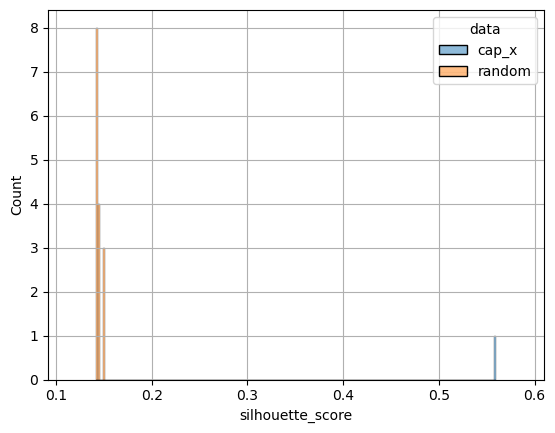

In [10]:
sns.histplot(data=results_df, x = 'silhouette_score', hue = 'data')
sil_max = results_df['silhouette_score'].max()
sil_min = results_df['silhouette_score'].min()
plt.xlim([sil_min - .05, sil_max + 0.05])
plt.grid()
plt.show()